In [1]:
import warnings
warnings.simplefilter(action='ignore')

import anndata as an
import scanpy as sc
import scarches as sca
import numpy as np
import gdown
import os

 captum (see https://github.com/pytorch/captum).


Make a folder with needed datasets in it.

In [10]:
adata = an.read_h5ad("../dataset/tyser.h5ad") 

In [11]:
adata.X = adata.raw.X.copy()


In [12]:
if not os.path.exists("../metadata/reactome.gmt"):
    url = 'https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c'
    output = "../metadata/reactome.gmt"
    gdown.download(url, output, quiet=False)

In [13]:
sca.utils.add_annotations(adata, '../metadata/reactome.gmt', min_genes=12, clean=True)
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [14]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [15]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="sample_name",
    subset=True)

In [16]:
select_terms = adata.varm['I'].sum(0)>12
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [17]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [18]:
# Overlap bepalen tussen gen-namen in adata.raw.var en adata.var
overlap_mask = adata.raw.var['_index'].isin(adata.var['features'])

# Controleer of het masker overeenkomt met het aantal kolommen in adata.raw.X
print("Lengte van overlap_mask:", len(overlap_mask))
print("Aantal kolommen in adata.raw.X:", adata.raw.X.shape[1])

# Filter de matrix op basis van de overlappende genen
if len(overlap_mask) == adata.raw.X.shape[1]:
    # Omzetten naar dense matrix (indien nodig)
    raw_X_dense = adata.raw.X.toarray()
    
    # Filter de kolommen op basis van overlap_mask
    filtered_raw_X = raw_X_dense[:, overlap_mask.values]
    
    # Resultaat
    print("Gefilterde matrix shape:", filtered_raw_X.shape)
else:
    print("Dimensies komen niet overeen! Controleer adata.raw.var en adata.raw.X.")



# Stap 1: Zorg ervoor dat de gefilterde matrix in het float32 formaat is
filtered_raw_X_float32 = filtered_raw_X.astype(np.float32)

# Stap 2: Optioneel: Sla de matrix op als een numpy-bestand
np.save('filtered_raw_X_float32.npy', filtered_raw_X_float32)

# Stap 3: Kopieer de matrix naar adata.X
adata.X = filtered_raw_X_float32

# Controleer de dimensies en het datatype van adata.X
print("Vorm van adata.X:", adata.X.shape)
print("Datatype van adata.X:", adata.X.dtype)

Lengte van overlap_mask: 57490
Aantal kolommen in adata.raw.X: 57490
Gefilterde matrix shape: (1069, 1977)
Vorm van adata.X: (1069, 1977)
Datatype van adata.X: float32


In [19]:
intr_cvae = sca.models.EXPIMAP(
    adata=adata,
    condition_key='sample_name',
    hidden_layer_sizes=[256, 256, 256],
    recon_loss='nb'
)



INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1977 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 224
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  224 0 0 1 1977
	with hard mask.
Last Decoder layer: softmax


In [20]:
ALPHA = 0.7

In [21]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

intr_cvae.train(
    n_epochs=400,
    alpha_epoch_anneal=100,
    alpha=ALPHA,
    alpha_kl=0.5,
    weight_decay=0.,
    early_stoppinstudyg_kwargs=early_stopping_kwargs,
    use_early_stopstudyping=True,
    monitor_only_val=False,
    seed=2020,
)



Preparing (1069, 1977)
Instantiating dataset
Init the group lasso proximal operator for the main terms.
 |████████████████████| 100.0%  - epoch_loss: 2924.6290588379 - epoch_recon_loss: 2774.4311523438 - epoch_kl_loss: 300.3959045410 - val_loss: 3188.3957519531 - val_recon_loss: 3043.9697265625 - val_kl_loss: 288.852050781268
Saving best state of network...
Best State was in Epoch 398


In [22]:
MEAN = False

In [23]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN, only_active=True)
sc.pp.neighbors(adata, use_rep='X_cvae')
sc.tl.umap(adata)


Adata:
orig.ident	nCount_RNA	nFeature_RNA	Source.Name	Characteristics.sampling.site.	Characteristics.inferred.cell.type...authors.labels.	Characteristics.inferred.cell.type...ontology.labels.	cluster_id	sub_cluster	origin	run	sample_name	timepoint	percent.mt

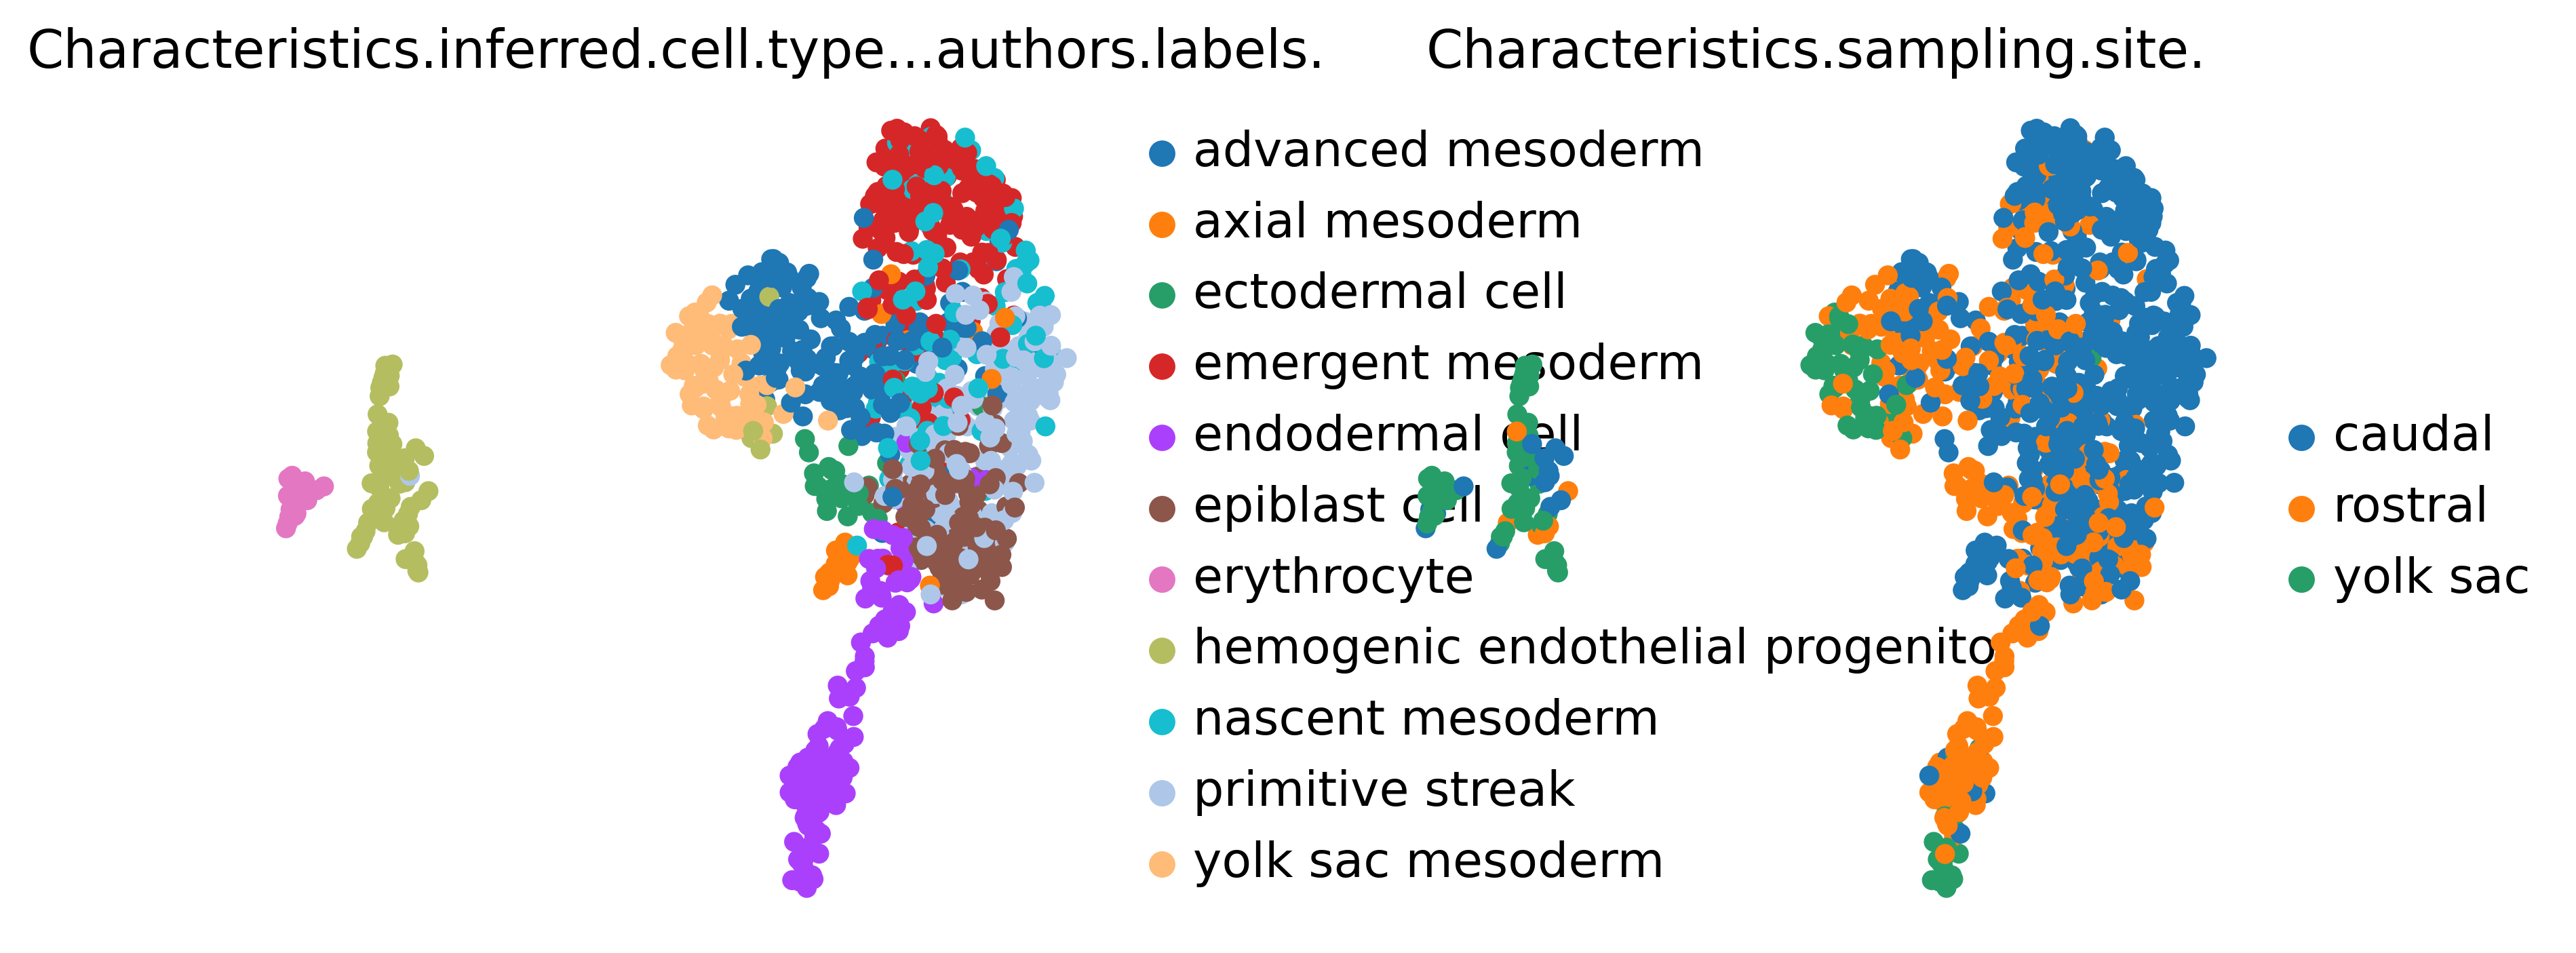

In [24]:
sc.pl.umap(adata, color=['Characteristics.inferred.cell.type...authors.labels.',"Characteristics.sampling.site."], frameon=False)

In [25]:

hips = sc.read('../dataset/hiPSC.h5ad')

In [26]:
common_var_names = adata.var_names.intersection(hips.var_names)
hips = hips[:, common_var_names].copy()

In [27]:
q_intr_cvae = sca.models.EXPIMAP.load("hips_tips_querry",adata)

Query data is missing expression data of  2  genes which were contained in the reference dataset.
The missing information will be filled with zeroes.
Query data contains expression data of  2  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 1069 × 1977
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Source.Name', 'Characteristics.sampling.site.', 'Characteristics.inferred.cell.type...authors.labels.', 'Characteristics.inferred.cell.type...ontology.labels.', 'cluster_id', 'sub_cluster', 'origin', 'run', 'sample_name', 'timepoint', 'percent.mt'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1977 256 5
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 224
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  224 0 0 5 1977
	with hard mask.
Last Decoder 

In [28]:
q_intr_cvae.train(n_epochs=400, alpha_epoch_anneal=100, weight_decay=0., alpha_kl=0.1, seed=2020, use_early_stopping=True)

Preparing (1069, 1977)
Instantiating dataset
 |████████████--------| 60.8%  - val_loss: 3576.9421386719 - val_recon_loss: 3485.3364257812 - val_kl_loss: 916.05621337896
ADJUSTED LR
 |████████████--------| 62.5%  - val_loss: 3555.3530273438 - val_recon_loss: 3464.2448730469 - val_kl_loss: 911.0806274414
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 228


In [29]:
try:
    q_intr_cvae.save('hips_tips_querry')
except:
    print("file is already existing")

file is already existing


In [ ]:
merged_datasets = sc.AnnData.concatenate(adata, hips, batch_key='batch_join', uns_merge='same')

In [ ]:
merged_datasets

AnnData object with n_obs × n_vars = 5763 × 1841
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Source.Name', 'Characteristics.sampling.site.', 'Characteristics.inferred.cell.type...authors.labels.', 'Characteristics.inferred.cell.type...ontology.labels.', 'cluster_id', 'sub_cluster', 'origin', 'run', 'sample_name', 'timepoint', 'percent.mt', 'percent.dissoc', 'RNA_snn_res.0.3', 'seurat_clusters', 'RNA_snn_res.0.22', 'batch_join'
    var: 'features', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0'
    obsm: 'X_umap'

In [ ]:
sc.pp.neighbors(merged_datasets)
sc.tl.umap(merged_datasets)

In [ ]:
merged_datasets.obs

,orig.ident,nCount_RNA,nFeature_RNA,Source.Name,Characteristics.sampling.site.,Characteristics.inferred.cell.type...authors.labels.,Characteristics.inferred.cell.type...ontology.labels.,cluster_id,sub_cluster,origin,run,sample_name,timepoint,percent.mt,percent.dissoc,RNA_snn_res.0.3,seurat_clusters,RNA_snn_res.0.22,batch_join
SS.sc7786612-0,0,259888.990001,6942,SS.sc7786612,rostral,endodermal cell,endodermal cell,Endoderm,DE(P),tyser,tyser,tyser,tyser,1.304482,NaN,NaN,NaN,NaN,0
SS.sc7786605-0,0,437911.014986,6140,SS.sc7786605,rostral,advanced mesoderm,mesoderm cell,Advanced Mesoderm,Advanced Mesoderm,tyser,tyser,tyser,tyser,1.295160,NaN,NaN,NaN,NaN,0
SS.sc7785737-0,0,322351.983054,3800,SS.sc7785737,caudal,primitive streak,primitive streak cell,Primitive Streak,Primitive Streak,tyser,tyser,tyser,tyser,1.294179,NaN,NaN,NaN,NaN,0
SS.sc7785398-0,0,394318.996000,2964,SS.sc7785398,yolk sac,yolk sac mesoderm,mesenchyme of yolk sac,ExE Mesoderm,YS Mesoderm,tyser,tyser,tyser,tyser,1.423720,NaN,NaN,NaN,NaN,0
SS.sc7788091-0,0,298217.993000,5030,SS.sc7788091,caudal,axial mesoderm,chordamesodermal cell,Axial Mesoderm,Axial Mesoderm,tyser,tyser,tyser,tyser,1.327328,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
batch_1_sample_120H_TTTACTGCATCCGCGA-1-1,SeuratProject,14013.000000,4629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120h,iPSC_72_1,NaN,4.767002,0.017398,3,2,2.0,1
batch_1_sample_120H_TTTCACATCAGCCCAG-1-1,SeuratProject,21173.000000,5140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120h,iPSC_72_1,NaN,4.127899,0.014142,5,4,4.0,1
batch_1_sample_120H_TTTCAGTAGTACAGAT-1-1,SeuratProject,22107.000000,5437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120h,iPSC_72_1,NaN,2.035554,0.013721,3,2,2.0,1
batch_1_sample_120H_TTTGATCAGCTCCATA-1-1,SeuratProject,12806.000000,4127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120h,iPSC_72_1,NaN,3.428081,0.015297,3,2,2.0,1


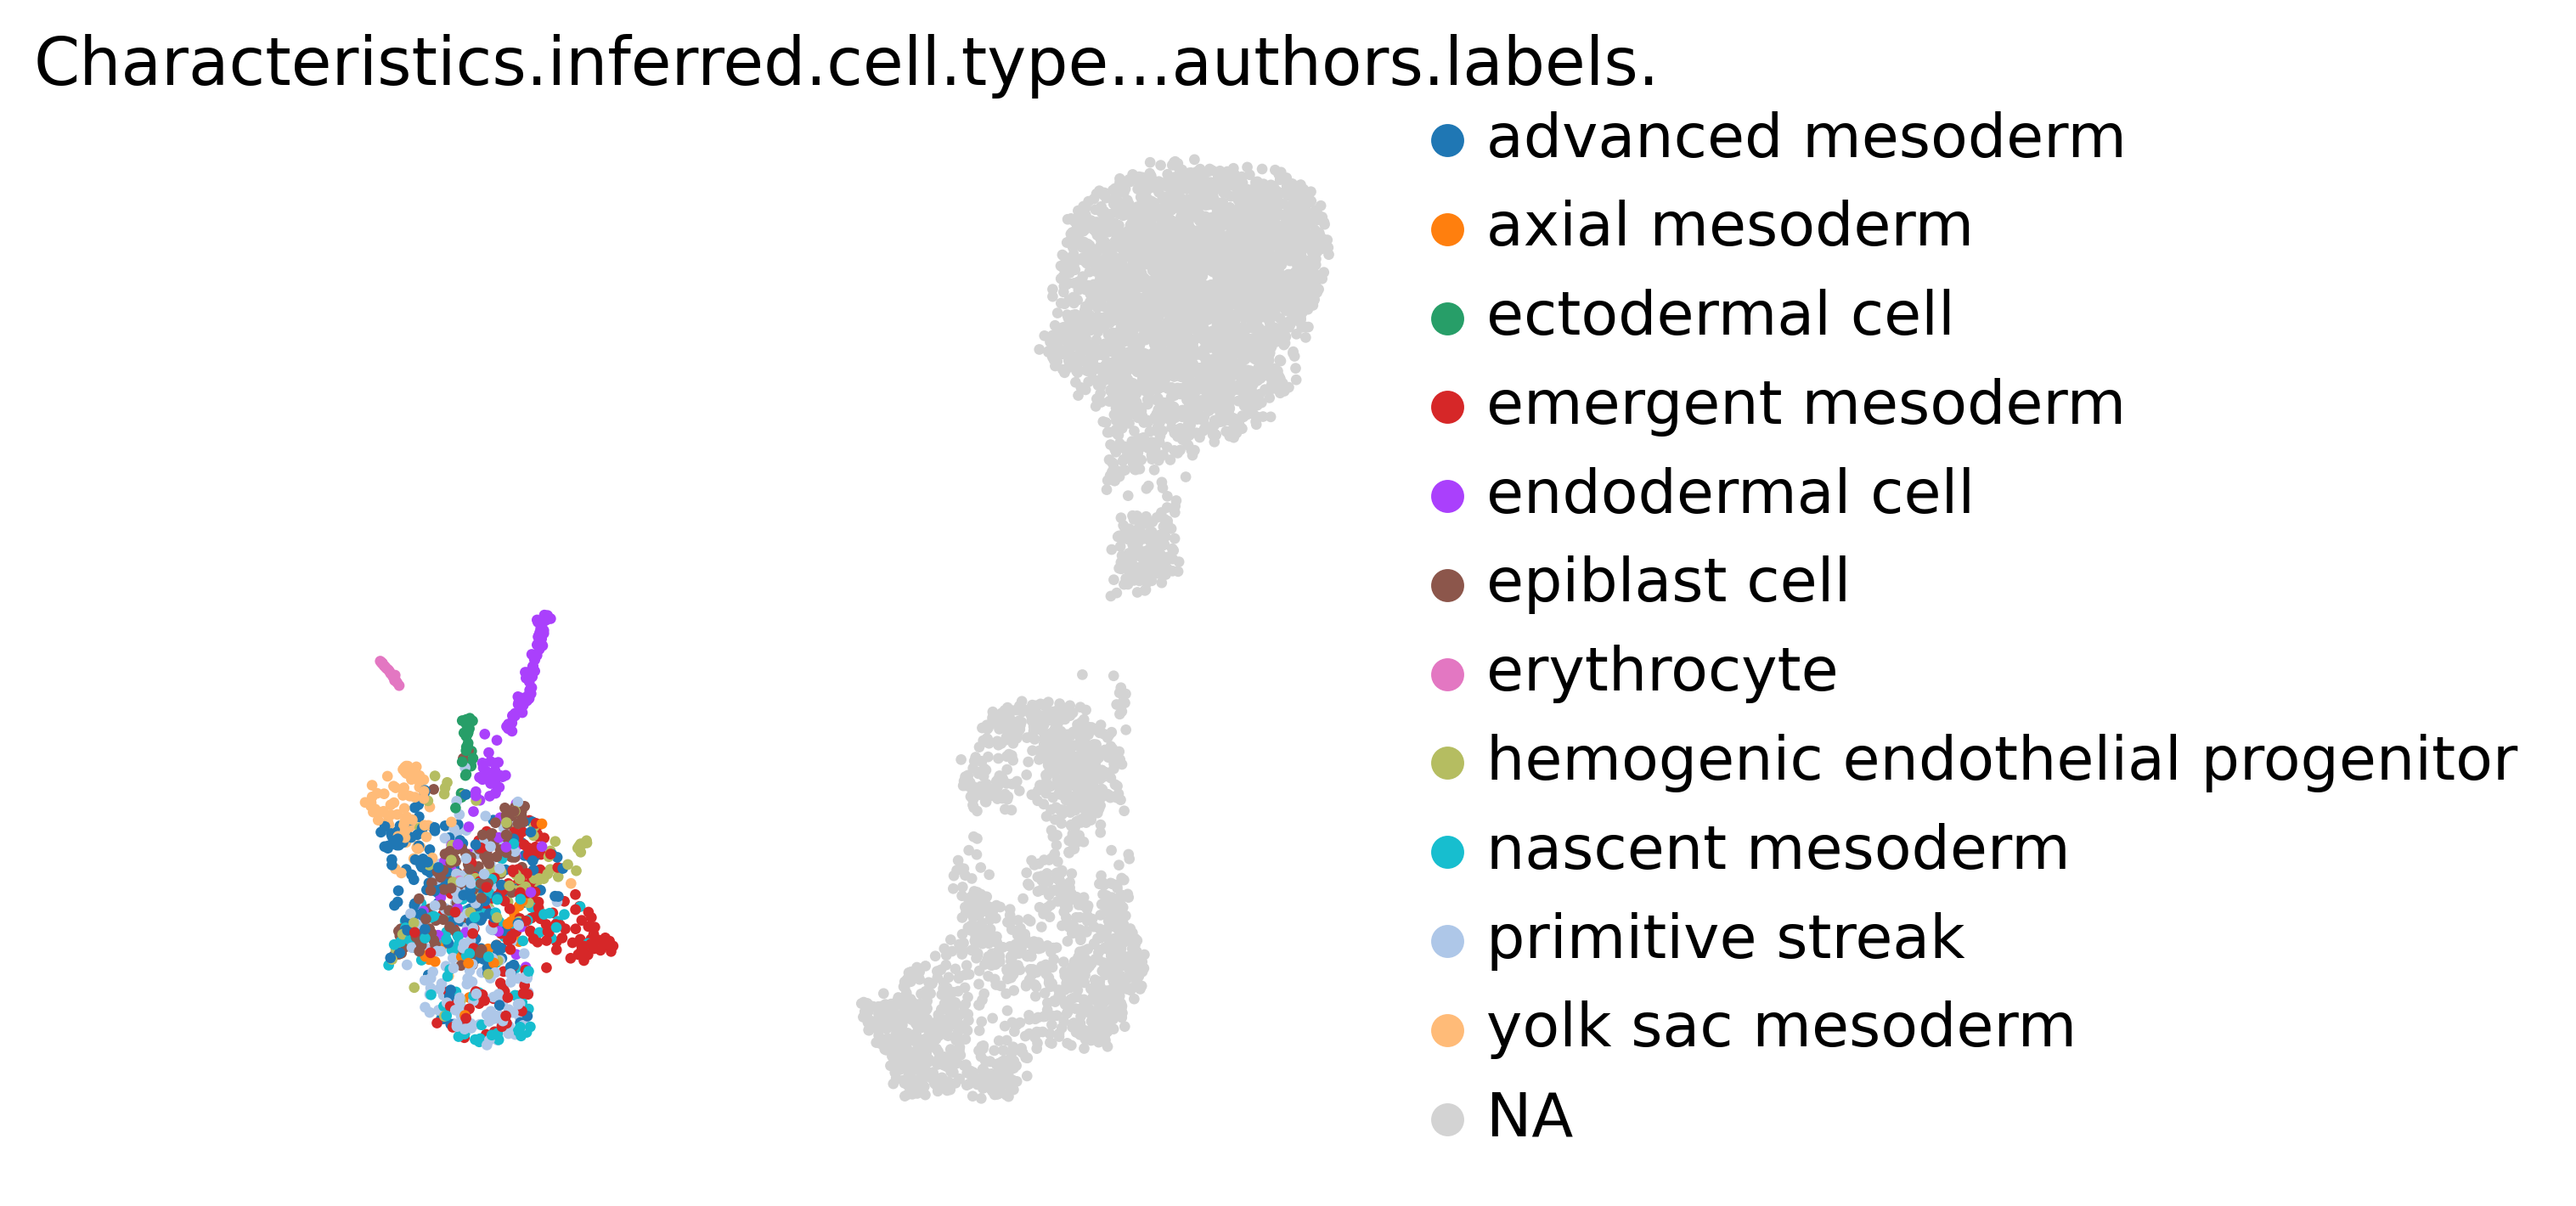

In [ ]:
sc.pl.umap(merged_datasets, color=['Characteristics.inferred.cell.type...authors.labels.'], frameon=False, wspace=0.6)